In [14]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'

In [4]:
from astropy import units as u

In [5]:
from spectral_cube import SpectralCube

In [6]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '146_spw51'
fmin = 147.035*u.GHz # ch3cncube.spectral_axis.min() # I should not have to hard-code these... but I don't want other lines creeping in
fmax = 147.175*u.GHz # ch3cncube.spectral_axis.max()

In [7]:
cube = SpectralCube.read(results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image')

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [8]:
import regions

In [34]:
reg = regions.Regions.read('../centralcoreellipse.reg')

In [35]:
scube = cube.subcube_from_regions(reg)
scube

DaskVaryingResolutionSpectralCube with shape=(3840, 17, 17) and unit=Jy / beam and chunk size (128, 10, 17):
 n_x:     17  type_x: RA---SIN  unit_x: deg    range:   266.543777 deg:  266.544790 deg
 n_y:     17  type_y: DEC--SIN  unit_y: deg    range:   -28.705319 deg:  -28.704431 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 145582599820.702 Hz:147457166014.871 Hz

In [19]:
m0 = scube.spectral_slab(147.15*u.GHz, 147.156*u.GHz).moment0() # slab of comps 0 and 1

/blue/adamginsburg/adamginsburg/repos/radio-beam/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


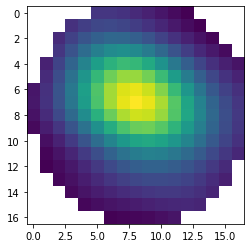

In [25]:
m0.quicklook()

In [86]:
avgspec = (scube.spectral_slab(147.000*u.GHz, 147.195*u.GHz) * m0.value).sum(axis=(1,2)) / np.nansum(m0.value)

In [31]:
meanspec = scube.spectral_slab(fmin, fmax).mean(axis=(1,2))

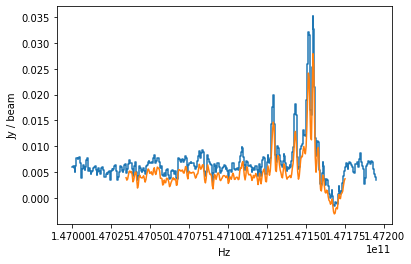

In [87]:
avgspec.quicklook()
pl.plot(meanspec.spectral_axis, meanspec.value)

In [37]:
from astropy.io import fits

In [38]:
tmap = fits.open('temperature_map_februrary.fits')

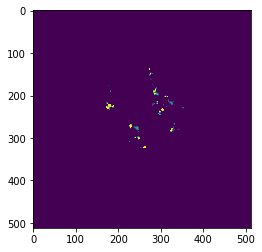

In [42]:
pl.imshow(tmap[0].data, vmin=50, vmax=200)

In [63]:
jtok = avgspec.beams.common_beam().jtok(avgspec.spectral_axis).mean()

In [448]:
import pyspeckit
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters, generate_fitter
from pyspeckit.spectrum.models import lte_molecule
from pyspeckit.spectrum.models.model import SpectralModel

In [449]:
sp = pyspeckit.Spectrum(data=(avgspec - np.median(avgspec.quantity))*jtok/avgspec.unit, xarr=avgspec.spectral_axis)

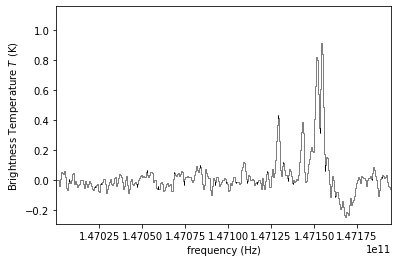

In [450]:
sp.plotter()

In [451]:
v_cen = 40*u.km/u.s
v_disp = 2*u.km/u.s
temp = 167*u.K
N_tot = 1e16*u.cm**-2
species = 'CH3CN'
freqs, aij, deg, EU, partfunc = get_molecular_parameters(species, fmin = fmin, fmax = fmax)
mod = lte_molecule.generate_model(sp.xarr, v_cen, v_disp, temp, N_tot,
                                  freqs, aij, deg, EU, partfunc)
def modfunc(xarr, vcen, width, tex, column, fillingfactor=0.02):
    if column < 100:
        column = 10**column
    return lte_molecule.generate_model(xarr, vcen, width, tex, column,
                                       freqs, aij, deg, EU, partfunc)*fillingfactor


In [452]:
sp.xarr.convert_to_unit(u.km/u.s, refX=freqs[-1], velocity_convention='radio')

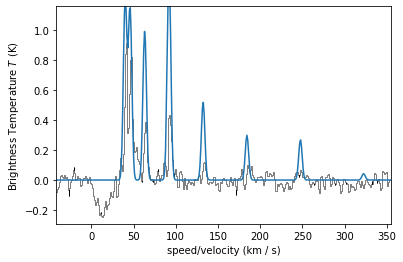

In [453]:
mod = modfunc(sp.xarr, v_cen.value, v_disp.value, temp.value, N_tot.value)
sp.plotter()
sp.plotter.axis.plot(sp.xarr, mod)

In [454]:
fitter = SpectralModel(modfunc, 4,
            parnames=['shift','width','tex','column'],
            parlimited=[(False,False),(True,False),(True,False),(True,False)],
            parlimits=[(0,0), (0,0), (0,0),(0,0)],
            shortvarnames=(r'\Delta x',r'\sigma','T_{ex}','N'),
            centroid_par='shift',
            )
fitter.__name__ = "CH3CN"

sp.specfit.Registry.multifitters['CH3CN'] = fitter
sp.specfit.Registry.npars['CH3CN'] = 4

sp.specfit(fittype='CH3CN', guesses=[40.1, 1.5, 155.1, 1e15], debug=True)

INFO: selectregion kwargs: {} use_window_limits: None reset: False xmin: None xmax: None [pyspeckit.spectrum.interactive]
Number of free parameters: 4 out of 4
initial fnorm=2.16082688816178
initial params=[4.010e+01 1.500e+00 1.551e+02 1.000e+15]
Entering calc_covar...


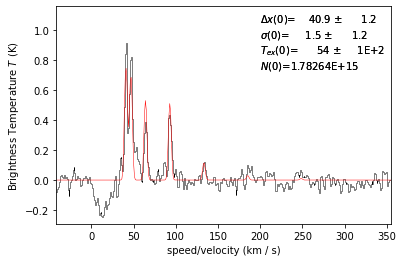

In [455]:
sp.plotter()
sp.specfit.plot_fit()

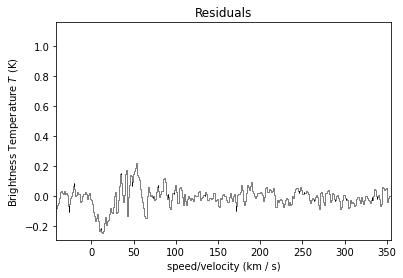

In [456]:
sp.specfit.plotresiduals()

In [457]:
fitter = SpectralModel(modfunc, 5,
            parnames=['shift','width','tex','column','ff'],
            parlimited=[(False,False),(True,False),(True,False),(True,False),(True,True)],
            parlimits=[(0,0), (0,0), (0,0),(0,0),(0,1)],
            shortvarnames=(r'\Delta x',r'\sigma','T_{ex}','N','ff'),
            centroid_par='shift',
            )
fitter.__name__ = "CH3CN"

sp.specfit.Registry.multifitters['CH3CN'] = fitter
sp.specfit.Registry.npars['CH3CN'] = 5

sp.specfit(fittype='CH3CN', guesses=[40.1, 1.5, 155.1, 15, 0.012], use_lmfit=True)

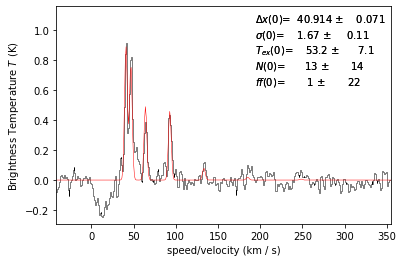

In [458]:
sp.plotter()
sp.specfit.plot_fit()

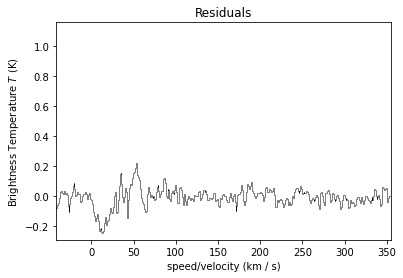

In [459]:
sp.specfit.plotresiduals()

(-1.0, 1.5)

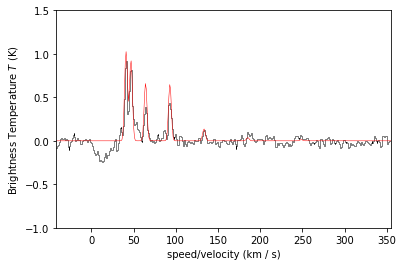

In [474]:
sp.plotter()
sp.specfit.plot_model([41.05, 1.6, 57, 1e15, 0.04])
sp.plotter.axis.set_ylim(-1,1.5)

In [395]:
dcube = SpectralCube.read('/orange/adamginsburg/brick_alma_linesurvey/danwalker/Brick_CH3CN.image.fits')

In [396]:
reg = regions.Regions.read('../centralcoreellipse.reg')

In [397]:
dscube = dcube.subcube_from_regions(reg)
dscube

SpectralCube with shape=(700, 117, 114) and unit=Jy / beam:
 n_x:    114  type_x: RA---SIN  unit_x: deg    range:   266.543732 deg:  266.544806 deg
 n_y:    117  type_y: DEC--SIN  unit_y: deg    range:   -28.705359 deg:  -28.704392 deg
 n_s:    700  type_s: VRAD      unit_s: m / s  range:   -63094.684 m / s:  400457.822 m / s

In [398]:
m0 = dscube.with_spectral_unit(u.GHz).spectral_slab(220.71*u.GHz, 220.72*u.GHz).moment0() # slab of comps 0 and 1

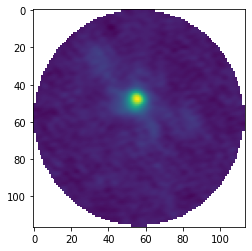

In [399]:
m0.quicklook()

In [420]:
np.unravel_index(np.nanargmax(m0), m0.shape)

(48, 56)

In [421]:
#davgspec = (dscube * m0.value).sum(axis=(1,2)) / np.nansum(m0.value)
davgspec = dscube[:,48,56]

In [422]:
djtok = davgspec.beam.jtok(davgspec.with_spectral_unit(u.GHz).spectral_axis).mean()

In [423]:
dsp = pyspeckit.Spectrum(data=(davgspec - np.median(davgspec.quantity))*djtok/davgspec.unit, xarr=davgspec.with_spectral_unit(u.GHz).spectral_axis)

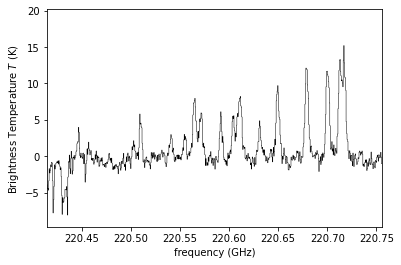

In [424]:
dsp.plotter()

In [425]:

species = 'CH3CN'
freqs, aij, deg, EU, partfunc = get_molecular_parameters(species, fmin = 220.3*u.GHz, fmax = 220.9*u.GHz)
mod = lte_molecule.generate_model(sp.xarr, v_cen, v_disp, temp, N_tot,
                                  freqs, aij, deg, EU, partfunc)
def modfunc(xarr, vcen, width, tex, column, fillingfactor=1):
    if column < 100:
        column = 10**column
    return lte_molecule.generate_model(xarr, vcen, width, tex, column,
                                       freqs, aij, deg, EU, partfunc)*fillingfactor


In [428]:
fitter = SpectralModel(modfunc, 5,
            parnames=['shift','width','tex','column','ff'],
            parlimited=[(False,False),(True,False),(True,False),(True,False),(True,True)],
            parlimits=[(0,0), (0,0), (0,0),(0,0),(0,1)],
            shortvarnames=(r'\Delta x',r'\sigma','T_{ex}','N','ff'),
            centroid_par='shift',
            )
fitter.__name__ = "CH3CN"

dsp.specfit.Registry.multifitters['CH3CN'] = fitter
dsp.specfit.Registry.npars['CH3CN'] = 5



(-5.0, 30.0)

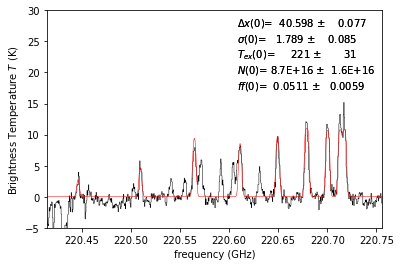

In [431]:
dsp.specfit(fittype='CH3CN', guesses=[40.1, 1.5, 195.1, 1e16, 1], use_lmfit=True)
dsp.plotter()
dsp.specfit.plot_fit()
dsp.plotter.axis.set_ylim(-5,30)

(-5.0, 30.0)

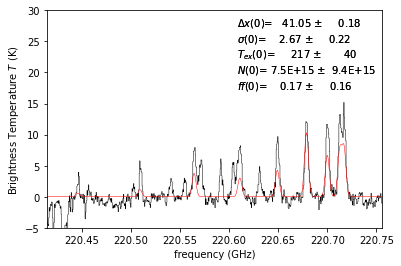

In [432]:
dsp.specfit(fittype='CH3CN', guesses=[40.1, 1.5, 105.1, 1e16, 1], use_lmfit=True)
dsp.plotter()
dsp.specfit.plot_fit()
dsp.plotter.axis.set_ylim(-5,30)

# Looking at Dan's parameters

(-5.0, 30.0)

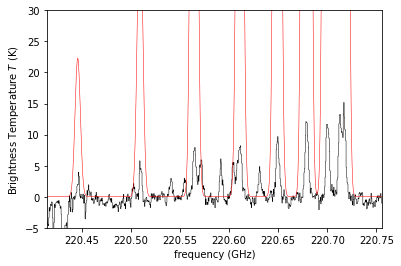

In [435]:
dsp.plotter()
dsp.specfit.plot_model([41.05, 3.6, 167, 8.9e16, 1])
dsp.plotter.axis.set_ylim(-5,30)

(-5.0, 30.0)

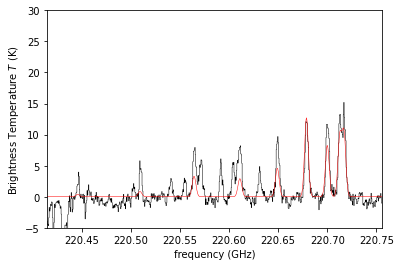

In [440]:
dsp.plotter()
dsp.specfit.plot_model([41.05, 2.6, 167, 1e15, 1])
dsp.plotter.axis.set_ylim(-5,30)

(-5.0, 30.0)

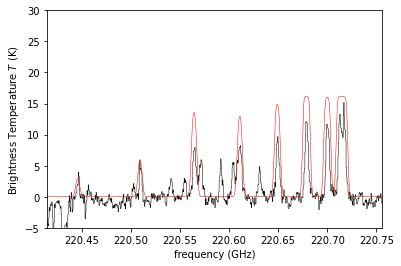

In [443]:
dsp.plotter()
dsp.specfit.plot_model([41.05, 2.6, 167, 8.9e16, 0.1])
dsp.plotter.axis.set_ylim(-5,30)